# 04. PyTorch Custom Datasets

Using PyTorch on custom datasets. The example we'll be using is of images of pizza, steak and sushi.

## 0. Importing PyTorch and setting up device-agnostic code

In [16]:
import torch
from torch import nn

In [17]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get Data 

We'll be using a subset of the [Food101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) dataset.

Food101 is a popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods.

We'll start with 3: pizza, steak and sushi.

And instead of starting with 1000 images per class, we'll start with 10%: 100 images (start small, increase when necessary).

In [18]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f"{image_path} already exists, skipping download")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak sushi data
    with open(data_path / "pizza_steak_sushi.zip", 'wb') as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak and sushi data...")
        f.write(request.content)
    
    # Unzip data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping the pizza, steak and sushi data...")
        zip_ref.extractall(image_path)
        print("Unzipped the data")

data\pizza_steak_sushi already exists, skipping download


## 2. Become one with the data (Data Preparation)

For a computer vision classification model, e.g. if we had to seperate between a dog and a cat, our dataset would contain 2 folders: 1 named dog and another named cat, each containing images only of the corresponding animal.

Our model follows the same structure.

To inspect what's inside our data directory, we can write a small helper function which uses `os.walk()`

In [19]:
import os
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents
    Args:
        dir_path (str or pathlib.Path): target directory
    
    Returns:
        Number of subdirectories in dir_path
        Number of images (files) in each subdirectory
        Name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")
    

In [20]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi.
There are 3 directories and 0 images in data\pizza_steak_sushi\test.
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza.
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak.
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi.
There are 3 directories and 0 images in data\pizza_steak_sushi\train.
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza.
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak.
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi.


In [21]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize and Image

1. Get all of the image paths using `pathlib.Path.glob()` to find all the files ending in `.jpg`.
2. Pick a random image path using Python's `random.choice`
3. Get image class name using `pathlib.Path.parent.stem`
4. And since we're working with images, we'll open the random image path using `PIL.Image.open()`.
5. Show the image and print some metadata

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


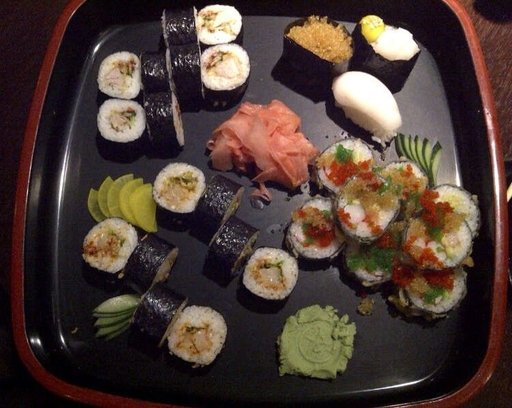

In [27]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all the image paths (* means any combination)
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (image class is the name of the directory)
image_class = random_image_path.parent.name

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

We can display the image directly using PIL, if we want to display an image using `matplotlib.pyplot.imshow()`, we have to convert it into a Numpy array first.

(-0.5, 511.5, 407.5, -0.5)

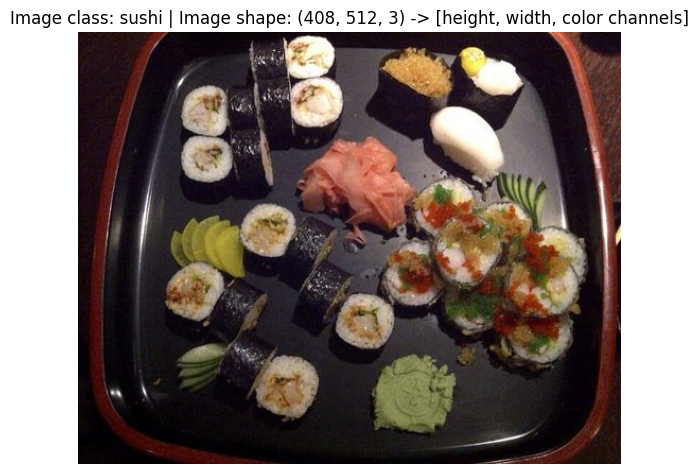

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(7, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels]")
plt.axis(False)

## 3. Transforming Data

Before loading our image data into PyTorch, we need to:
1. Turn images into tensors
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`, we'll call these `Dataset` and `Dataloader` for short.

In [33]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`.

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for *data augmentation* purposes.

**Data augmentation**: The practice of altering data to make it harder for a model to learn.

Let's write a series of transformation steps:
1. Resize image using `transforms.Resize()` from about 512x512 to 64x64.
2. Flip our images randomly on the horizontal using `transforms.RandomHorizontalFlip()` (can be considered data augmentation as we artificially change our data).
3. Turn our images from PIL Image to PyTorch tensor using `transforms.ToTensor()`.

We can combine all of these steps using `torchvision.transforms.Compose()`

In [35]:
# Write transforms for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),         # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor()           # Also converts all pixel values from 0-255 to 0-1
])

Now that we have a composition of transforms, let's write a function to try them out on various images.

In [46]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """ Plots a series of random images from image_paths:
    
    Will open n image paths from image_paths, transform them with transform and plot them side by side.
    
    Args:
        image_paths (list): List of target image paths
        transform (PyTorch Transforms): Transforms to apply to images
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis('off')
            
            # Transform and plot image
            # Note: permute() will change shape of image to support matplotlib
            # PyTorch default: [C, H, W] -> Matplotlib default: [H, W, C]
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis('off')
            
            fig.suptitle(f"Class: {image_path.parent.name}", fontsize=16)

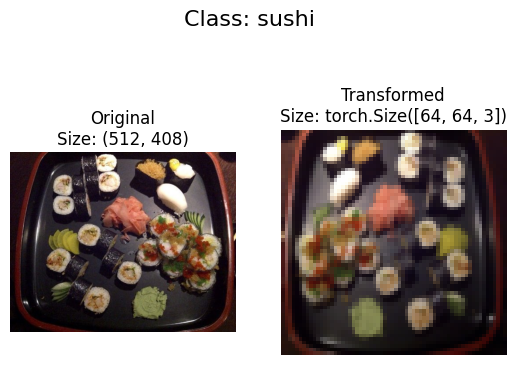

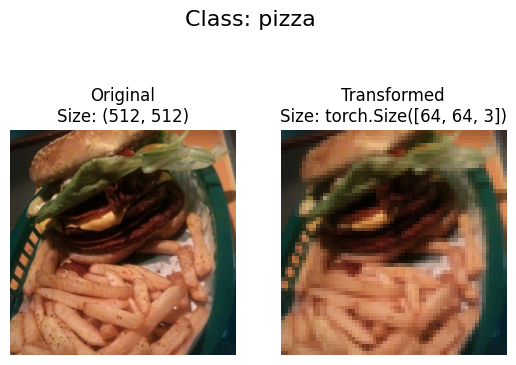

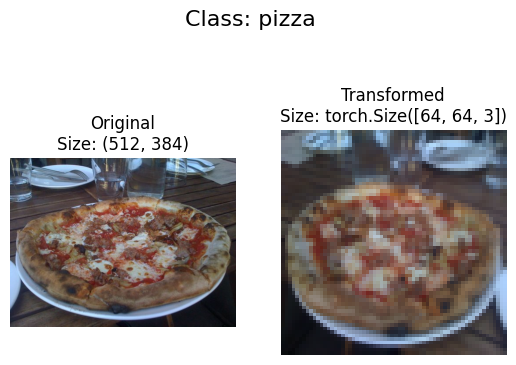

In [47]:
plot_transformed_images(image_path_list, transform=data_transform, n=3)

Now we can convert our images using `torchvision.transforms`.